In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import ManifoldSculpting_v2 as ms
from ManifoldSculpting_gabri import ManifoldSculpting as ms_gabri

from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, LocallyLinearEmbedding

from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.metrics import mean_squared_error

import os

import time

In [2]:
data_folder = '../data/'
X = np.load(data_folder + "SwissRoll3D/N_2000.npy")
X_2D = np.load(data_folder + "SwissRoll2D/N_2000.npy")

In [7]:
cov = np.cov(X.T)
eigval,eig = np.linalg.eig(cov)
index = np.argsort(-eigval)
eigvec = np.copy(eig[:,index].astype(np.float32))

X_pca = X@eigvec

In [25]:
def alignAxesPC(data, Dpres: list):

        """Aligns the axes of the dataset P using the Principal Components method.

        Parameters:
        - data: dataset to be aligned, with shape (N, D), where N is the number of points and D is the number of dimensions
        - Dpres: number of dimensions to be preserved
        """

        N_points = data.shape[0]
        D = data.shape[1]
        Dscal = np.arange(D)
        Dscal = np.delete(Dscal, Dpres)
        print(Dscal)
        # Center the data
        mean: float = np.mean(data, axis=0) # Mean for every dimension
        data -= mean

        Q = np.copy(data)

        G = np.eye(D) # Matrix of standard basis vectors

        # Find principal components
        for k in len(Dpres):
            c = np.random.rand(D) # Random vector of dimension D

            for _ in range(10):
                t = np.zeros(D)

                for q in Q: # For each row of Q
                    t += np.dot(q, c) * q
                c = t / np.linalg.norm(t)

            for q in Q: # For each row of Q
                q -= np.dot(c, q) * c
            
            a = G[:, k]

            b = (c - np.dot(a, c) * a) / np.linalg.norm(c - np.dot(a, c) * a)

            phi  = np.arctan(np.dot(b, c) / np.dot(a, c))

            for j in range(k, len(Dscal)):
                u = np.dot(a, G[:, j])
                v = np.dot(b, G[:, j])

                G[:, j] -= u * a
                G[:, j] -= v * b

                r = np.sqrt(u * u + v * v)
                theta = np.arctan(v / u)

                u = r * np.cos(theta + phi)
                v = r * np.sin(theta + phi)

                G[:, j] += u * a
                G[:, j] += v * b
        
        for i in range(N_points):
            for j in range(D):
                data[i, j] = np.dot(data[i, :], G[:, j]) + mean[j]
        
        return data

X_aligned = alignAxesPC(X, [0, 1])

[2]


/var/folders/q5/4d_bg8zn7h74dy6rjkx80q4w0000gn/T/ipykernel_87971/3812770426.py:51: RuntimeWarning: divide by zero encountered in scalar divide
  theta = np.arctan(v / u)


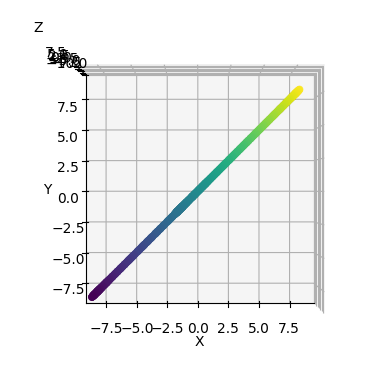

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax1 = fig.add_subplot(111, projection='3d')
# ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=X_2D[:,0], cmap='viridis')
ax.scatter(X_aligned[:,0], X_aligned[:,1], X_aligned[:,2], c=X_aligned[:,0], cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(90, 270)
